In [7]:
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, Activation, MaxPool2D, concatenate
from tensorflow.keras import activations
from keras.callbacks import TensorBoard
from tensorflow import keras

import skimage

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
(train_y, _), (test_y, _) = cifar100.load_data()
train_y = train_y.astype('float32') / 255
test_y = test_y.astype('float32') / 255
train_X = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in train_y], axis=3)
test_X = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in test_y], axis=3)

169001437/169001437 [==============================] - 88s 1us/step


In [10]:
plt.rc('figure', figsize=(12, 8), dpi=100)
def show_imgs(img1, img2):
  fig, (ax1, ax2) = plt.subplots(ncols=2)
  ax1.imshow(img1.reshape(32, 32), cmap='gray')
  ax2.imshow(img2)
  ax1.set_xlabel('input')
  ax2.set_xlabel('output')
  plt.show()

In [24]:
train_X.shape

(50000, 32, 32, 1)

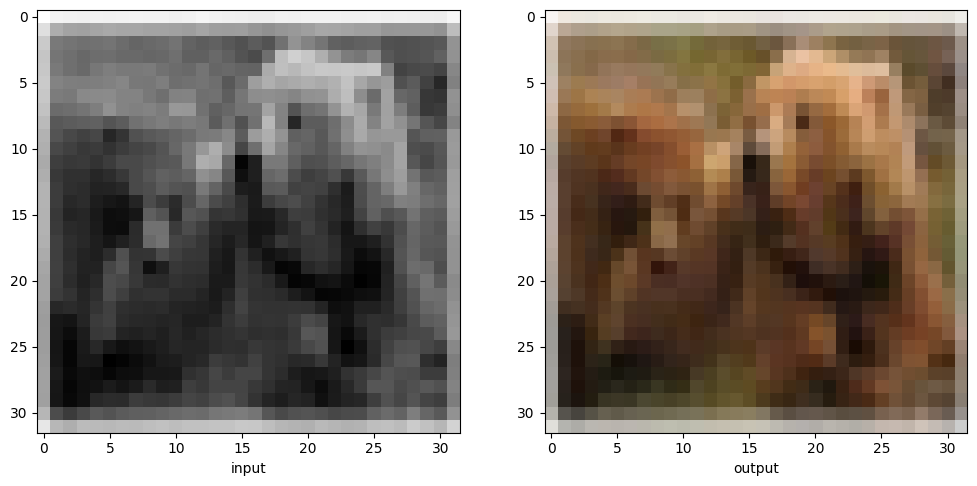

In [26]:
show_imgs(train_X[-3], train_y[-3])

## Weight decay

In [34]:
from keras.regularizers import l2
def init_autoencoder_with_weight_decay(name, filters, kernel_size, dropout: float = 0.0, weight_decay=0.01):
  model = Sequential(name=name)
  for nf in filters:
    model.add(Conv2D(nf, kernel_size, padding='same', strides=2, kernel_regularizer=l2(weight_decay), bias_regularizer = l2(weight_decay)))
    model.add(Activation('relu'))
  for nf in filters[::-1]:
    model.add(Conv2DTranspose(filters=nf, kernel_size=kernel_size, strides=2, activation='relu', padding = 'same'))
  model.add(Conv2D(filters = 3, kernel_size = kernel_size, activation='sigmoid', padding='same'))  
  return model

In [35]:
def train_small_model_with_weight_decay(name, dataset_train, dataset_val, BATCH_SIZE, epochs=1, weight_decay=0.01):
  model = init_autoencoder_with_weight_decay(name, filters = [64, 128, 256], kernel_size=3, weight_decay=weight_decay)
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=optimizer, loss='mse')
  model.history = model.fit(dataset_train[0], dataset_train[1], epochs=epochs, batch_size=BATCH_SIZE, validation_data=(dataset_val[0], dataset_val[1]))
  return model

In [36]:
def different_weight_decays():
  weight_decays = [0.0000001, 0.000001, 0.000005, 0.0001]
  models = {}
  for weight_decay in weight_decays:
    name=f"small_decay_{weight_decay}"
    model = train_small_model_with_weight_decay(name=name, dataset_train=(train_X, train_y), dataset_val=(test_X, test_y), BATCH_SIZE=64, weight_decay=weight_decay)
    models[name] = model
  return models

In [37]:
decayed = different_weight_decays()

782/782 [==============================] - 244s 311ms/step - loss: 0.0189 - val_loss: 0.0135


In [38]:
my_model = decayed['small_decay_1e-07']

1/1 [==============================] - 0s 137ms/step


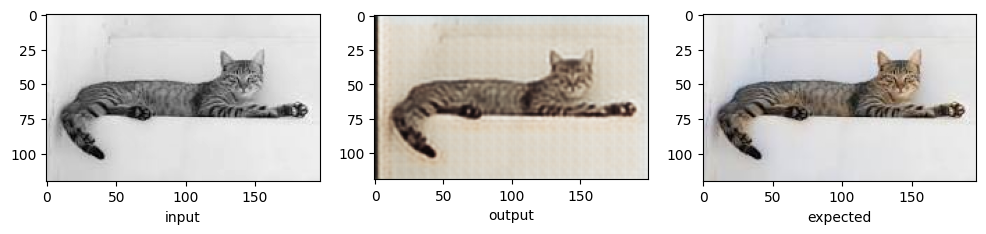

In [43]:
def plot_result(x, y, Y):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
  ax1.imshow(x.reshape(x.shape[0], x.shape[1]), cmap='gray')
  ax2.imshow(Y)
  ax3.imshow(y)
  ax1.set_xlabel('input')
  ax2.set_xlabel('output')
  ax3.set_xlabel('expected')

def plot_disk_image(model, path):
  y = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB).astype('float32') / 255
  x = cv.cvtColor(y, cv.COLOR_RGB2GRAY)
  Y = model.predict(x.reshape(1, x.shape[0], x.shape[1], 1))[0]
  plot_result(x, y, Y)

plot_disk_image(my_model, 'C:/Users/thoma/Pictures/1.jpg')

1/1 [==============================] - 0s 84ms/step


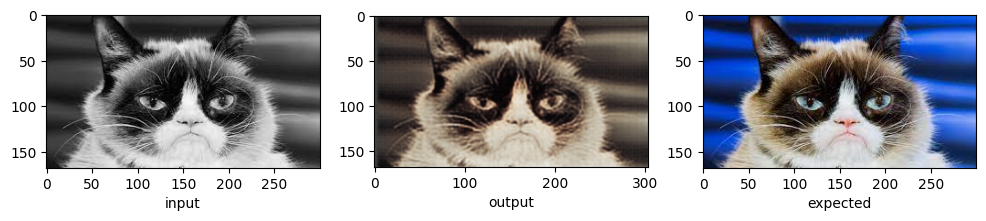

In [47]:
plot_disk_image(my_model, 'C:/Users/thoma/Pictures/4.jpg')